<a href="https://colab.research.google.com/github/FajarKKP/Face_Mask_Detection/blob/main/Notebooks/facemask_detection_development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Face Mask Detection Model**

This notebook is for face mask detection model development. The model that is being used as the backbone is YOLO5 nano. Yolo5 nano is choosen because of several reasons:

1.   One of the lightest model for object detection but industrial proven. Good for deployment.
2.   YOLO as an architecture is a single-stage detection, which enables end-to-end detection in a single forward pass. This is usefull for real-time processing.


The dataset that will be used for this development is this face mask kaggle dataset https://www.kaggle.com/datasets/andrewmvd/face-mask-detection. This dataset is choosen due to its diverse image with sufficient amount.

It contains around 800 dataset seperated into 3 classes (Mask, no mask and incorrect mask use).



**Data Loading and Exploration**

Data will be loaded from the gdrive. After going through the roboflow process, the dataset is split based on train/valid/test with a 70 / 20 / 10 split. Or more accurately after preprocess and data augmentation, this model will use 593 / 170 / 85 images, totalling at 848.

The based on the data exploration and observation, this dataset in general is good with lots of images that have different face mask. The only downside is the unbalance amount of data with the label mask_wear_incorrect where it lacks compared to the other label. That is why it is important to seperate them equally as best as we can into the train / val / test dataset.

In [ ]:
# Mount and link our gdrive to this notebook.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set up and install yolov5
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


**Preprocessing and Data Augmentation Steps**

The preprocessing and data augmentation step, it is done using roboflow. Roboflow is used due to its ease  of use on preparing datasets and a lot of it feature is usefull to enrich the dataset.

For the preprocessing steps, images are undergone througn the auto-orient process. This is done to correct images visual orientation based on their EXIF orientation metadata.

For the data augmentation step, the images will not undergone that process. Data augmentation is used to further enhance dataset diversity and make model robust. But the drawback is that more dataset = more training time, which currently the author does not have. That is why for this model development, data augmentation step will not be used. If more time is given in the future, this step could be introduced again.

The preprocessing and data augmentation step is done outside the colab or training process to increase training speed. The drawback is that the dataset is "fixed" and any changes to it can only be done outside the colab. But the pros of faster training and less resource usage is choosen to justify this decision.

In [ ]:
# Train on yolov5 nano
# Use AdamW optimizer because it is better for small scale dataset and limited computational resources.
# Use --cache flag to preload dataset into ram. this can increase training speed by removing repeated I/O action.
# Early stopiing (the --patience flag) is used to stop the training process if the model did not show a significant improvement after a set of epochs.
# Batch size 8 and epochs 150 is a good starting point for training. Not too long for training but enough for the model to understand pattern.
# Image size 416 is chosen due to its ability to still make model learn while staying efficient. It is also good start for edge deployment model.

%cd /content/yolov5

!python train.py \
    --img 416 \
    --batch 8 \
    --epochs 150 \
    --data /content/drive/MyDrive/facemask_ori/data.yaml \
    --weights yolov5n.pt \
    --project /content/drive/MyDrive/Facemask_results/train \
    --name facemask_detection \
    --cache \
    --optimizer AdamW \
    --patience 10

Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
     56/149         0G     0.0332    0.02475   0.005361         46        416:  87% 65/75 [02:16<00:18,  1.88s/it]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
     56/149         0G    0.03322     0.0248   0.005343         69        416:  88% 66/75 [02:17<00:16,  1.85s/it]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
     56/149         0G    0.03318    0.02477   0.005297         48        416:  89% 67/75 [02:20<00:16,  2.03s/it]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):


After getting the model, we can use and test it using the test dataset. Below is the code for it.

In [ ]:
# For yolov5 inference
# It will use the weights from our previous trained model and use the test dataset to test.
# We can test the model by adjusting the test image size for more practical use-case (example if the model is to be deployed on edge devices)
# The --device force the inference or testing to be only done using CPU, a good benchmark if the model is going to be deployed for edge case
!python val.py \
  --weights /content/drive/MyDrive/Facemask_results/train/facemask_detection5/weights/best.pt \
  --data /content/drive/MyDrive/facemask_ori/data.yaml \
  --img 416 \
  --task test \
  --device cpu

val: data=/content/drive/MyDrive/facemask_ori/data.yaml, weights=['/content/drive/MyDrive/Facemask_results/train/facemask_detection5/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=cpu, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-453-geed9bc19 Python-3.12.12 torch-2.9.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 1763224 parameters, 0 gradients, 4.1 GFLOPs
test: Scanning /content/drive/MyDrive/facemask_ori/test/labels... 85 images, 0 backgrounds, 0 corrupt: 100% 85/85 [01:06<00:00,  1.28it/s]
test: New cache created: /content/drive/MyDrive/facemask_ori/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 3/3 [00:21<00:00,  7.29s/it]
                   all         85        416      0.721      0.5

Done with the testing, we can further use the model for deployment. The code below will export the model into ONNX format and ready to be used.

In [ ]:
# Export yolo5 nano weight in ONNX. The export process will be done using CPU only.
# The flag --simplify will optimize the onnx model, making the model smaller and faster.
# The flag --dynamic enables the onnx model to be used using any kinds of image size during deployment, a great flexibility option.
# Image size here determines the real-case image that the model will encounter. 416 is a good size for edge deployment or for efficiency sake.

!python export.py \
    --weights /content/drive/MyDrive/Facemask_results/train/facemask_detection5/weights/best.pt \
    --imgsz 416 \
    --include onnx \
    --simplify \
    --device cpu \
    --dynamic

export: data=data/coco128.yaml, weights=['/content/drive/MyDrive/Facemask_results/train/facemask_detection5/weights/best.pt'], imgsz=[416], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=True, cache=, simplify=True, mlmodel=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-453-geed9bc19 Python-3.12.12 torch-2.9.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 1763224 parameters, 0 gradients, 4.1 GFLOPs

PyTorch: starting from /content/drive/MyDrive/Facemask_results/train/facemask_detection5/weights/best.pt with output shape (1, 10647, 8) (3.6 MB)
requirements: Ultralytics requirement ['onnxscript'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 8 packages in 248ms
Prepared 2 packages in 75ms
Installed 2 packages in 13ms
 + onnx-ir==0.1.14
 + onnx

**Conclusion**

The goal of this development is to produce a model for a face mask detection use. Using a face mask dataset from kaggle, this development has shown that the goal is achieved.

For further explanation, we can analyze the model results when tested on the test set. From there, we can then judge how well the model performed.

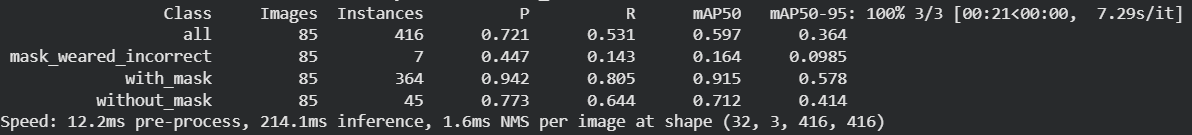

At a glance, we can see a disparity in perfomance between the mask_wear_incorrect label with the other class. This is the issue because of the data inbalance. Because of how scarce it is even during training, it makes the model unable to detect well this class compared to the other 2.

We can see that in general it works as intended with decent performance. Precision shows that the model correctly categorize the face mask in the image. Recall shows how the model can detect the face mask in the image. The score for these categories are decent in the with_mask and without_mask class. Again due to data inbalance, the precision and recall for the mask_wear_incorrect is very poor.

mAP50 and mAP50-95 also shows the same pattern. mAP50 tells us how good a model find and detect the object (in this case face mask) through the overlapping label. mAP50-95 is a much stricter and focus more on localization (like how precise the bounding box is). The same pattern shows itself in these categories. Score is good for with_mask and without_mask class. A drop in score related to mask_wear_incorrect class just shows how the model cannot precisely detect and recognise this class.



All in all, the model shows great performance on detecting the with_mask and without_mask class. It performs poorly on mask_wear_incorrectly. Further improvement on the mask_wear_incorrectly class may help the model to be more ready for deployment.

**Further Improvement**

This model development is done within 3 days. Which means there are a lot of areas where it can be improved when given time.

1. Dataset Gathering. The current dataset that is used is taken in diffent region and by a third-party. For better and accurate performance, dataset should be taken from the customer or the region where this project will be used.
2. Data augmentation step is not used due to time and resource constraint. This step can be used to further make a more robust model if the time and resource requirement is met.
3. Architecture test. Further test using different architecture types (ex: Faster R-CNN, SSD, RetinaNet, etc) or even different YOLO architecure (ex: YOLO8, YOLO11, YOLO8 nano) could perhaps gives more option for deployment.
4. More in-depth hyperparameter testing. Such as testing different kinds of optimizer, image size or batch. We can even test how to use the model efficiently (ex: the minimum dataset that is required to stil give a good performance).
5. Further model optimization (ex: using prunning to produce more efficient model).
5. Testing with a real-life case or real client condition. This to further show that the model can perform as intended and be used by the client.



**Additional Test**

For deployment purpose and ease of use, author will train the face mask detection on YOLOv8 nano. This is done due to the current deployment environment (CLI and all) is made around YOLOv8. This is just to show how the model that has been trained in this notebook can be further used in an end-to-end pipeline.

In [ ]:
# Install YOLOv8 (Ultralytics)
!pip install ultralytics

# Import the library
from ultralytics import YOLO

# Load a YOLOv8 nano model (pretrained)
model = YOLO("yolov8n.pt")  # 'n' is nano

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Train on yolov8 nano
model.train(
    data="/content/drive/MyDrive/facemask_ori/data.yaml",
    imgsz=416,
    batch=8,
    epochs=200,
    project="/content/drive/MyDrive/Facemask_results/train",
    name="facemask_yolov8n",
    cache=True,
    patience=10
)

Ultralytics 8.4.2 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/facemask_ori/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=facemask_yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, pe

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ba016276780>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

After finishing training, we can then take the YOLOv8 model to be used in the sytem.